In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [50]:
X = np.load('X.npy')
Y = np.load('Y.npy')

In [51]:
from sklearn.preprocessing import LabelEncoder
Y = LabelEncoder().fit_transform(Y)

In [52]:
X = X.astype('float32')
y = Y.astype('int64')

In [53]:
X /= 255.0

In [54]:
X.min(), X.max()

(0.0, 1.0)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
X_train.shape, y_train.shape

((52933, 1024), (52933,))

In [9]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 32, 32), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

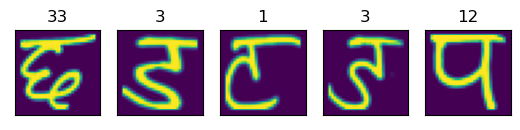

In [10]:
plot_example(X_train, y_train)

In [11]:


import torch
from torch import nn
import torch.nn.functional as F



In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
mnist_dim = X.shape[1]
hidden_dim_1 = int(mnist_dim/2)
hidden_dim_2 = int(mnist_dim/4)
output_dim = len(np.unique(Y))

In [16]:
mnist_dim, hidden_dim_1, hidden_dim_2, output_dim

(1024, 512, 256, 36)

In [26]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dim_1=hidden_dim_1,
            hidden_dim_2=hidden_dim_2,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim_1)
        self.hidden_1 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.output = nn.Linear(hidden_dim_2, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = F.relu(self.hidden_1(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

In [27]:
from skorch import NeuralNetClassifier

In [36]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=30,
    lr=0.1,
    device=device,
)

In [37]:
net.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.5648       0.5931        1.5213  2.3415
      2        1.4606       0.6846        1.1561  2.5916
      3        1.1682       0.7517        0.9086  2.2726
      4        0.9525       0.7925        0.7487  1.9419
      5        0.7916       0.8242        0.6318  2.8519
      6        0.6697       0.8492        0.5492  2.7987
      7        0.5774       0.8650        0.4879  2.8008
      8        0.5061       0.8755        0.4447  2.9177
      9        0.4469       0.8847        0.4136  3.2855
     10        0.3958       0.8964        0.3733  3.7357
     11        0.3580       0.8979        0.3690  2.9977
     12        0.3271       0.9064        0.3370  2.8678
     13        0.2937       0.9049        0.3357  2.9287
     14        0.2633       0.9120        0.3115  2.8322
     15        0.2404       0.9112        0.3156  2.9000
     16        0.2242       0.9

In [38]:
from sklearn.metrics import accuracy_score

In [39]:
y_pred = net.predict(X_test)

In [40]:
accuracy_score(y_test, y_pred)

0.932275432133749

In [41]:
error_mask = y_pred != y_test

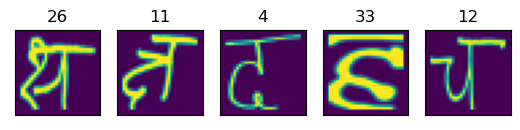

In [42]:
plot_example(X_test[error_mask], y_pred[error_mask])  #SOME BAD PREDICTION

# CNN

In [43]:
1024/32


32.0

In [67]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(2304, 100) # 2304 = number channels * width * height
        self.fc2 = nn.Linear(100, 36)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # flatten over channel, height and width = 2304
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        
        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [80]:
2304/16

144.0

In [68]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [77]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=25,
    lr=0.0002,
    optimizer=torch.optim.Adam,
    device=DEVICE,
    iterator_train__num_workers=4,
    iterator_valid__num_workers=4,
    #callbacks=callbacks,
)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X.reshape(70578,1,32,32), y, test_size=0.25, random_state=42)

In [78]:
cnn.fit(X_train, y=y_train);

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.8813       0.6141        1.6206  25.2352
      2        1.7045       0.7670        0.9489  26.0941
      3        1.2740       0.8278        0.6850  28.6138
      4        1.0532       0.8571        0.5456  26.9171
      5        0.9133       0.8748        0.4627  26.7618
      6        0.8311       0.8911        0.4095  27.0445
      7        0.7611       0.8953        0.3818  26.8944
      8        0.7174       0.9029        0.3470  25.4342
      9        0.6787       0.9102        0.3257  25.7061
     10        0.6430       0.9159        0.3053  25.8426
     11        0.6108       0.9200        0.2911  25.5205
     12        0.5944       0.9238        0.2748  25.1723
     13        0.5740       0.9276        0.2600  25.5823
     14        0.5550       0.9293        0.2538  25.3695
     15        0.5392       0.9317        0.2442  25.3345
     16       

In [79]:
y_pred_cnn = cnn.predict(X_test)
print(accuracy_score(y_test, y_pred_cnn))
accuracy_score(y_test[error_mask], y_pred_cnn[error_mask])

0.9492774156984981


0.597489539748954